In [1]:

from attorch.dataset import ListDataset
from blinkende_lichter.datatools import RandomFlip, TypeConversion 
from torchvision import transforms 
from torch.utils.data import DataLoader 
import numpy as np 
import torch

from PIL import Image
from argparse import ArgumentParser

from torch.optim import Adam
from torch.autograd import Variable

from blinkende_lichter.unet.network import UNet
from blinkende_lichter.unet.criterion import CrossEntropyLoss2d

from random import randint
import matplotlib.pyplot as plt
import random

In [5]:
transform = transforms.Compose([    
    RandomFlip(),    
    TypeConversion(np.float32, np.long) ]) 
dat = np.load('../datasets/data_interpolated.npz')

tr = dat['train']
vd = dat['validation']
for image in tr[1]:
    for h in range(len(image)):
        for w in range(len(image[0])):
            if(image[h][w]==0):
                image[h][w]=0
            else:
                image[h][w] = 1
    

for image in vd[1]:
    for h in range(len(image)):
        for w in range(len(image[0])):
            if(image[h][w]==0):
                image[h][w]=0
            else:
                image[h][w] = 1
               


            
            
train = ListDataset(*tr, transform=transform)

val = ListDataset(*vd) 
trainloader = DataLoader( train, shuffle=True, batch_size=1) 




torch.Size([1, 2, 512, 512]) torch.Size([1, 512, 512])
torch.Size([1, 2, 512, 512]) torch.Size([1, 512, 512])


In [121]:
MAX_CHECKS = 10
best_score = None
checks = 0
NUM_CHANNELS = 2
NUM_CLASSES = 2


Net = UNet
model = Net(NUM_CLASSES)
model = model.cuda()
#model.load_state_dict(torch.load("model_data"))



        
    
        


In [50]:
def IOU(output, target):
    x = np.logical_or(output==1, target==1)
    return np.sum(target * output)/sum(x[x])

In [100]:

def evaluate(Net, test_values, loss_graph):
    Net.eval()
    global best_score, checks, MAX_CHECKS
    for i in range(len(test_values.data[0])):
        input = torch.FloatTensor(test_values.data[0][i]).cuda()
        target = Variable(torch.from_numpy(test_values.data[1][i])).cuda()
        output = Net(Variable(input).unsqueeze(0))
        val_loss = criterion(output, target.unsqueeze(0))
        
        score = val_loss.data[0]
        
        if score <= best_score:
            best_score = score
            checks = 0
        else:
            checks+=1
        loss_graph.append((score))
        if (checks>=MAX_CHECKS):
            print("Breaking")
            break

        


In [114]:
model.train()
weight = torch.ones(NUM_CLASSES)
weight[0] = 0
patience = 1800
criterion = CrossEntropyLoss2d()
optimizer = Adam(model.parameters())
epoch_loss = []
val_epoch_loss = []
#train_inputs = []
train_targets = []
train_outputs = []
#val_inputs = []
val_targets = []
val_outputs = []
for epoch in range(1, 2001):
    for step, (images, labels) in enumerate(trainloader):
        images = images.cuda()
        labels = labels.cuda()
        inputs = Variable(images)
        targets = Variable(labels)
        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        #train_inputs.append(inputs.data.cpu().numpy())
        #train_targets.append(targets.data.cpu().numpy())
        #if(epoch % 100 == 0):
            #train_targets.append(targets.data.cpu().numpy())
            #train_outputs.append(outputs.data.cpu().numpy())
        epoch_loss.append((loss.data[0]))
        
        

    model.eval()

    for i in range(len(val.data[0])):
        input = torch.FloatTensor(val.data[0][i]).cuda()
        target = Variable(torch.from_numpy(val.data[1][i])).cuda()
        output = model(Variable(input).unsqueeze(0))
        #val_inputs.append(input.cpu().numpy())
        x = np.exp(output.data.cpu().numpy())
        res = x/x.sum(1)
        pos = np.argmax(res, axis=1).squeeze()
        val_loss = IOU(pos, target.data.cpu().numpy())
        #if(epoch % 100==0):
        #val_outputs.append(output.data.cpu().numpy())
        #val_targets.append(target.data.cpu().numpy())
        val_epoch_loss.append(val_loss)
        
    
        if(epoch>=patience):
            if(len(val_epoch_loss) % 4 == 0):
                score = sum(val_epoch_loss[-4:])/len(val_epoch_loss[-4:])            
                if(best_score == None):
                    best_score = score
                if(score >= best_score):
                    best_score = score
                    checks = 0
                else:
                    checks+=1
                if (checks>=MAX_CHECKS):
                    break
                else:
                    continue
                break
            else:
                continue
            break
        else:
            continue
        break
    else:
        continue
    break
                    
torch.save(model.state_dict(), "model_data")
torch.save(epoch_loss, "loss")
print("Training and validation complete.")

Training and validation complete.


In [17]:
%matplotlib inline


In [ ]:
val_epoch_loss.index(best_score)

In [ ]:
tgt_img = val_targets[39]
out_data = val_outputs[39]
indicator  =  np.arange(out_data.shape[1]).reshape([1, -1, 1, 1])
np.sum(out_data*indicator, axis=1)
x = np.exp(out_data)
res = x/x.sum(1)

pos = np.argmax(res, axis=1).squeeze()


In [ ]:
%matplotlib inline
plt.figure()

plt.subplots(figsize=(12,12))

avg = plt.subplot(221)
corr = plt.subplot(222)
tgt = plt.subplot(223)
out = plt.subplot(224)

avg.title.set_text("Average Image")
corr.title.set_text("Correlation Image")
tgt.title.set_text("Target Image")
out.title.set_text("Output Image")

avg.imshow(in_img_avg)
corr.imshow(in_img_corr)
tgt.imshow(tgt_img)
out.imshow(pos.squeeze())



plt.tight_layout()

In [ ]:
del(x, res, pos)

In [ ]:

fig = plt.figure(figsize=(12,12))
plt.imshow(pos)


In [ ]:
val_outputs[-1].shape

In [ ]:

ol = np.zeros((len(pos),len(pos), 3))
for h in range(len(pos)):
    for w in range(len(pos)):
        ol[w][h][0]=tgt_img[w][h]
        ol[w][h][1]=pos[w][h]


In [ ]:
ol[ol==1]

In [ ]:

train_in = []
train_tgt = []
train_out = []
for i in range(4):
    r = randint(0,14)
    train_in.append(torch.FloatTensor(tr[0][r].astype(float)).cuda())
    train_tgt.append(torch.from_numpy(tr[1][r]).long())
    

In [ ]:
type(tr)

In [ ]:
model.eval()
for i in range(len(train_in)):
    out = model(Variable(train_in[i]).unsqueeze(0))
    train_out.append(out)

In [ ]:
train_out[3]

In [ ]:

    out_data = train_out[n].data.cpu().numpy()
    indicator  =  np.arange(out_data.shape[1]).reshape([1, -1, 1, 1])
    np.sum(out_data*indicator, axis=1)
    x = np.exp(out_data)
    res = x/x.sum(1)
    pos = np.argmax(res, axis=1)
    train_out_mod.append(pos.squeeze())

In [ ]:
targets.max()

In [ ]:
train_tgt

In [ ]:
model

In [ ]:
train_out_mod[1]

In [ ]:
range(5)

In [ ]:
plt.imshow(ol)

In [ ]:
fig = plt.figure(figsize=(12,12))
tgt = plt.subplot(221)
op = plt.subplot(222)
tgt.title.set_text("Target Image")
op.title.set_text("Output Image")
tgt.imshow(train_tgt[0].numpy())
op.imshow(train_out_mod[0])


In [ ]:
train_outputs[-1]

In [ ]:
val_outputs

In [ ]:
np.sum(tgt_img * pos)/((np.sum(tgt_img)+np.sum(pos))/2)

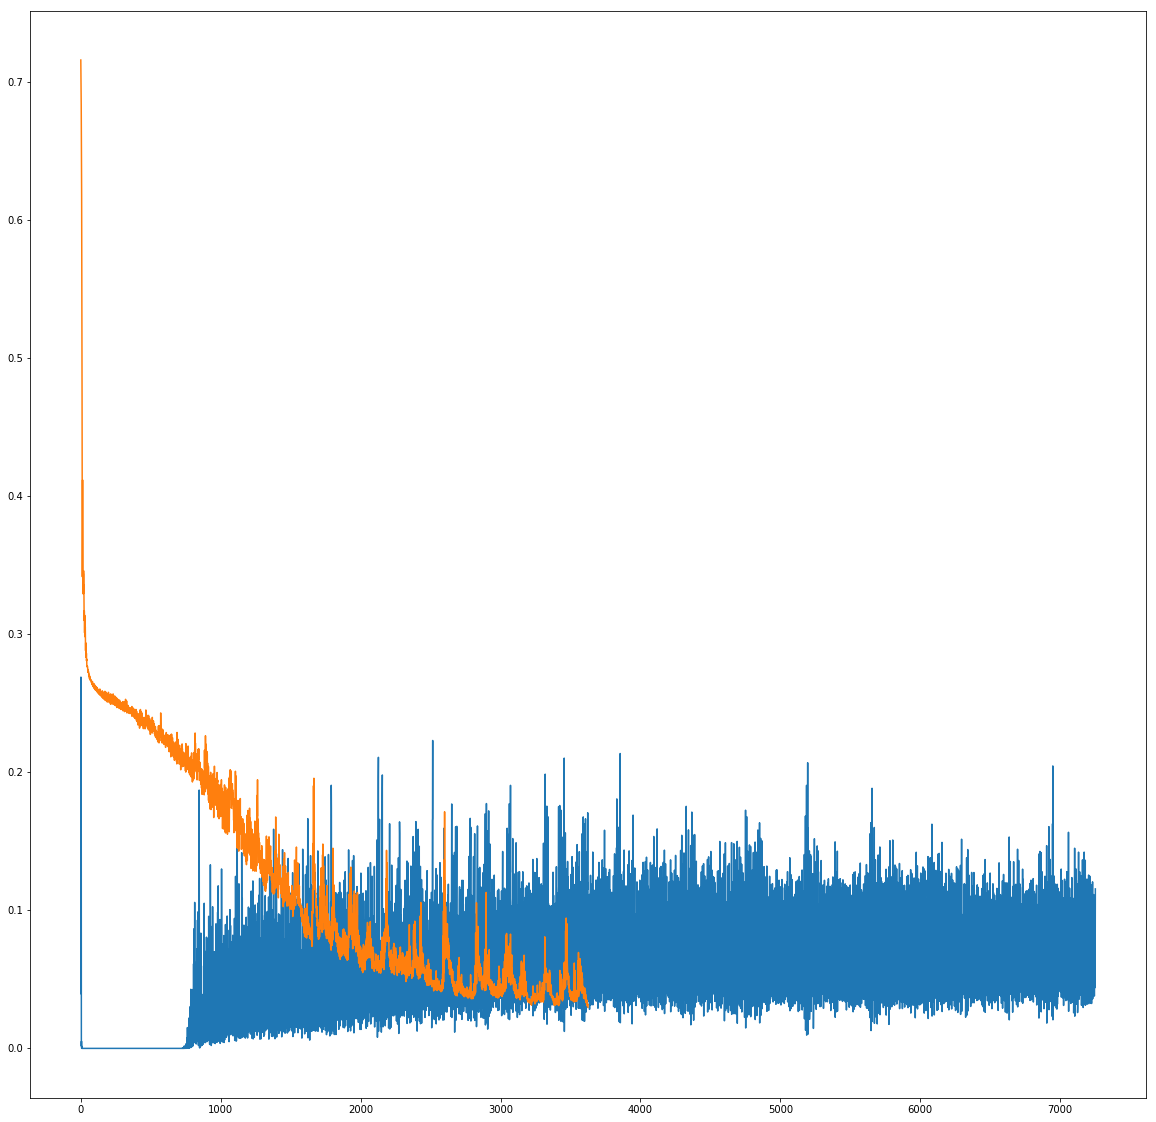

In [117]:
fig = plt.figure(figsize=(20,20))
plt.plot(val_epoch_loss)
plt.plot(epoch_loss)

plt.show()

In [ ]:
len(latest_loss)

In [ ]:
checks

In [ ]:
latest_val_loss

In [ ]:
enumerate(val_epoch_loss)

In [118]:
avg_ep = [epoch_loss[x:x+2] for x in range(0, len(epoch_loss), 2)]
avg_val_ep = [val_epoch_loss[x:x+4] for x in range(0, len(val_epoch_loss), 4)]


for i in range(len(avg_ep)):
    avg_ep[i]=sum(avg_ep[i])/len(avg_ep[i])

for i in range(len(avg_val_ep)):
    avg_val_ep[i]=sum(avg_val_ep[i])/len(avg_val_ep[i])

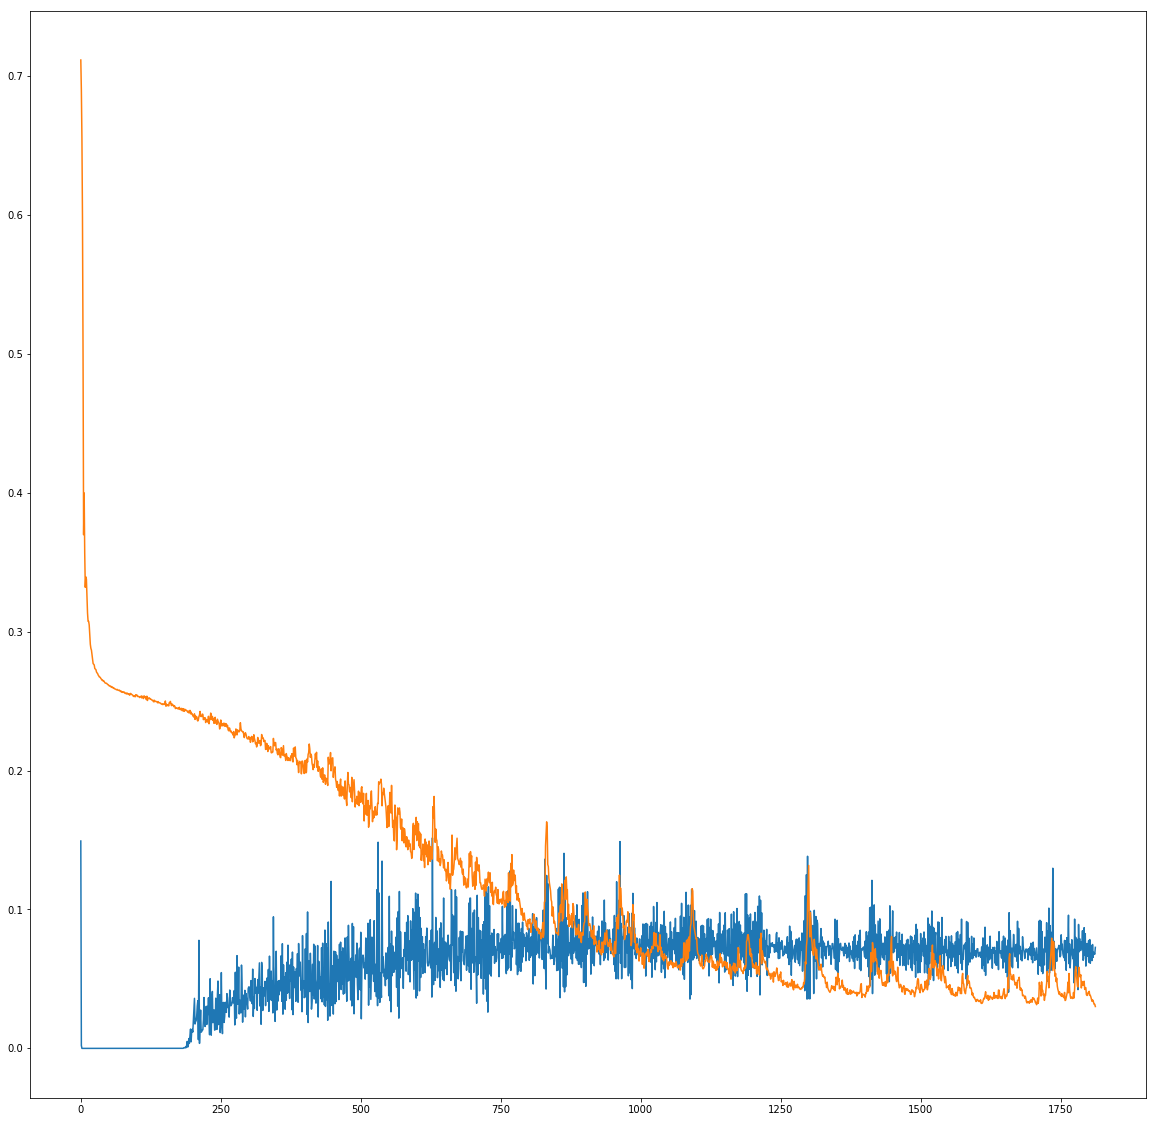

In [120]:
fig = plt.figure(figsize=(20, 20))
plt.plot(avg_val_ep)
plt.plot(avg_ep)



In [ ]:
del(target, output)

In [ ]:
for param in model.parameters():
    print(param.data, param.size())

In [ ]:
plt.show()

In [90]:
best_score

0.072769337073246579

In [47]:
sum(val_epoch_loss[3212:3216])/4

0.11872811522793386

In [68]:
len(val_epoch_loss)

3652

In [67]:
803 * 4

3212

In [ ]:
out_mod[36:]

In [ ]:
to_mod[0].max()

In [ ]:
plt.imshow(pos.squeeze())

In [ ]:
pos.squeeze()

In [41]:
range(0, len(val_epoch_loss),4)

range(0, 3256, 4)

In [ ]:
val_epoch_loss[0:4]

In [ ]:
f =[1,2,3,4]

In [ ]:
len(f)%4

In [91]:
avg_val_ep.index(best_score)

1504

In [ ]:
epoch

In [ ]:
score

In [ ]:
if (len(f) % 4 == 0):
    temp = f[-4:]

In [ ]:
temp

In [ ]:
sum(temp)/len(temp)

In [78]:
sum(val_epoch_loss[-4:])/4

0.042734724996952377

In [ ]:
epoch

In [ ]:
len(val_outputs)

In [ ]:
552/4

In [80]:
epoch

1011

In [ ]:
best_score

In [ ]:
min(avg_val_ep)

In [ ]:
val_outputs[38]

In [ ]:
fig = plt.figure(figsize=(12,12))
%matplotlib inline
plt.imshow(pos.squeeze())

In [ ]:
len(val_epoch_loss)

In [ ]:
len(val_outputs)

In [ ]:
sum(val_epoch_loss[508:512])/4

In [79]:
checks

10

In [ ]:
len(input)

In [ ]:
train_outputs[-1].max()

In [ ]:
v_out = train_out_part[64][0]

indicator  =  np.arange(v_out.shape[1]).reshape([1, -1, 1, 1])
np.sum(v_out*indicator, axis=1)
x = np.exp(v_out)
res = x/x.sum(1)
out_mod = res.squeeze()

true_out = np.zeros((len(out_mod[0]),len(out_mod[0]),3))

for h in range(0, len(out_mod[0])):
    for w in range(0, len(out_mod[0])):
        true_out[w][h][0]=out_mod[0][w][h]
        true_out[w][h][1]=out_mod[1][w][h]

fig = plt.figure(figsize=(12, 12))
plt.imshow(true_out)

In [ ]:
train_outputs[16].shape

In [ ]:
len(out_mod[0])

In [ ]:
plt.imshow(val_targets[74])

In [ ]:
in_img = val_inputs[74]
in_img_avg = in_img[0]
in_img_corr = in_img[1]
tgt_img = val_targets[74]

plt.figure()

plt.subplots(figsize=(12,12))

avg = plt.subplot(221)
corr = plt.subplot(222)
tgt = plt.subplot(223)
out = plt.subplot(224)

avg.title.set_text("Average Image")
corr.title.set_text("Correlation Image")
tgt.title.set_text("Target Image")
out.title.set_text("Output Image")

avg.imshow(in_img_avg)
corr.imshow(in_img_corr)
tgt.imshow(tgt_img)
out.imshow(true_out)


In [ ]:
len(val_outputs)

In [ ]:
val_out_part = [val_outputs[x:x+4] for x in range(0, len(val_outputs), 4)]

In [ ]:
val_target_part = [val_targets[x:x+4] for x in range(0, len(val_targets), 4)]

In [ ]:
len(train_outputs)

In [ ]:
train_out_part = [train_outputs[x:x+2] for x in range(0, len(train_outputs), 2)]

In [ ]:
train_target_part = [train_targets[x:x+2] for x in range(0, len(train_targets), 2)]

In [ ]:
len(train_target_part)

In [ ]:

show_train_1 = []
show_train_2 = []
show_train_3 = []
show_val_1 = []
show_val_2 = []
show_val_3 = []

In [ ]:
ax[0][0].imshow(true_out)


In [ ]:
%matplotlib inline

In [ ]:
for i in range(0, len(val_out_part)):
    v_out = val_out_part[i][0]

    indicator  =  np.arange(v_out.shape[1]).reshape([1, -1, 1, 1])
    np.sum(v_out*indicator, axis=1)
    x = np.exp(v_out)
    res = x/x.sum(1)
    out_mod = res.squeeze()

    true_out = np.zeros((len(out_mod[0]),len(out_mod[0]),3))

    for h in range(0, len(out_mod[0])):
        for w in range(0, len(out_mod[0])):
            true_out[w][h][0]=out_mod[0][w][h]
            true_out[w][h][1]=out_mod[1][w][h]

    show_val_1.append(true_out)
    show_val_2.append(np.argmax(res, axis=1).squeeze())

In [ ]:
len(show_val_1)

In [ ]:
train_inputs[16].shape

In [ ]:
len(train_outputs)

In [ ]:
test = [train_outputs[x:x+30] for x in range(0, len(train_outputs), 30)]

In [ ]:
del(test)

In [ ]:
for i in range(0, len(train_out_part)):
    v_out = train_out_part[i][0]

    indicator  =  np.arange(v_out.shape[1]).reshape([1, -1, 1, 1])
    np.sum(v_out*indicator, axis=1)
    x = np.exp(v_out)
    res = x/x.sum(1)
    out_mod = res.squeeze()

    true_out = np.zeros((len(out_mod[0]),len(out_mod[0]),3))

    for h in range(0, len(out_mod[0])):
        for w in range(0, len(out_mod[0])):
            true_out[w][h][0]=out_mod[0][w][h]
            true_out[w][h][1]=out_mod[1][w][h]

    show_train_1.append(true_out)
    show_train_2.append(np.argmax(res, axis=1).squeeze())

In [ ]:
for i in range(0, len(val_target_part)):
    show_val_3.append(val_target_part[i][0])

In [ ]:
for i in range(0, len(train_target_part)):
    show_train_3.append(train_target_part[i][0])

In [ ]:
plt.figure()
fig, ax = plt.subplots(nrows=6, ncols=10, figsize=(20,20))


In [ ]:
for i in range(0, len(show_val_1)):
    ax[0][i].imshow(show_train_1[i])
    ax[1][i].imshow(show_train_2[i])
    ax[2][i].imshow(show_train_3[i].squeeze())
    ax[3][i].imshow(show_val_1[i])
    ax[4][i].imshow(show_val_2[i])
    ax[5][i].imshow(show_val_3[i])
plt.tight_layout

In [ ]:
len(show_train_1)

In [ ]:
%matplotlib inline

In [ ]:
fig

In [ ]:
for i in range(2):
    print(i)

In [ ]:
for j in range(10):
    for i in range(6):
        ax[i][j].title.set_text(100*j)

In [ ]:
fig.subplots_adjust(wspace=1.5)

In [ ]:
ep_part = [epoch_loss[x:x+2] for x in range(0, len(epoch_loss), 2)]
val_ep_part = [val_epoch_loss[x:x+4] for x in range(0, len(val_epoch_loss), 4)]

In [ ]:
ep_part[0][0]

In [ ]:
for j in range(10):
    for i in range(3):
        ax[i][j].set_xlabel(ep_part[j][0])


In [ ]:
fig.subplots_adjust(wspace=1.5)

In [ ]:
for i in range(3,6):
    print(i)

In [ ]:
for j in range(10):
    for i in range(3,6):
        ax[i][j].set_xlabel(val_ep_part[j][0])

In [ ]:
len(train_outputs)

In [ ]:
tgt_train_img = train_targets[19]
out_train_data = train_outputs[19]
indicator  =  np.arange(out_train_data.shape[1]).reshape([1, -1, 1, 1])
np.sum(out_train_data*indicator, axis=1)
x_train = np.exp(out_train_data)
res_train = x/x.sum(1)

pos_train = np.argmax(res, axis=1).squeeze()


In [ ]:
ol_train = np.zeros((len(pos_train),len(pos_train), 3))
for h in range(len(pos_train)):
    for w in range(len(pos_train)):
        ol_train[w][h][0]=tgt_train_img.squeeze()[w][h]
        ol_train[w][h][1]=pos_train[w][h]

In [ ]:
[tgt_img==1]

In [ ]:
x = np.logical_or(tgt_img==1, pos==1)

In [ ]:
np.sum(tgt_img * pos)/(len(x[x==True]))

In [ ]:
IOU(pos, tgt_img)

In [ ]:
test = train_outputs[0]

In [ ]:
y = np.ones((200,200))

In [ ]:
np.logical_or(x==1, y==1)

In [ ]:
y[0][0]=0

In [ ]:
y[0][1]=0
x[0][1]=0

In [ ]:
np.sum(x[x])

In [ ]:
IOU(pos, tgt_img)

In [112]:
torch.save(best_score, "best_score_2000epoch_1700patience_10maxcheck")

In [82]:
torch.load("best_score_1000epoch_800patience_10maxcheck")

0.094470952936841088

In [83]:
torch.load("best_score_2000epoch_900patience_10maxcheck")

0.095973830187532971

In [84]:
torch.load("best_score_2000epoch_1000patience_10maxcheck")

0.0900829548123038

In [93]:
torch.load("best_score_2000epoch_1500patience_10maxcheck")

0.072769337073246579